In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftshift, ifftshift

In [2]:
class LaserBeamShaper:
    def __init__(self, spatial_freq, n_elements, intensity_lb, intensity_ub, aperture_support=None):
        self.k        = spatial_freq
        self.K        = spatial_freq.size
        self.M        = n_elements
        self.lb       = intensity_lb
        self.ub       = intensity_ub
        # aperture_support must be length M
        self.support  = np.ones(self.M) if aperture_support is None else aperture_support

    def aperture_to_focal(self, c):
        # Build zero-padded, centered K-vector
        pad = np.zeros(self.K, dtype=complex)
        start = (self.K - self.M)//2
        pad[start:start+self.M] = c
        # Shift so that center is at index 0, FFT, then shift back
        F = fftshift( fft(ifftshift(pad)) )
        return F

    def focal_to_aperture(self, F):
        # Shift back, IFFT, then pick out centered M-elements
        p = fftshift( ifft(ifftshift(F)) )
        start = (self.K - self.M)//2
        return p[start:start+self.M]

    def apply_intensity_constraints(self, F):
        amp = np.abs(F)
        phase = np.exp(1j*np.angle(F))
        amp_clipped = np.clip(amp, self.lb, self.ub)
        return amp_clipped * phase

    def optimize_beam(self, max_iter=5000, tol=1e-12, verbose=True):
        # Initial guess from lower-mask amplitude
        F0 = np.sqrt(self.lb)
        c = self.focal_to_aperture(F0) * self.support

        err = []
        for it in range(max_iter):
            F = self.aperture_to_focal(c)
            Fc = self.apply_intensity_constraints(F)
            c_new = self.focal_to_aperture(Fc) * self.support
            c_new = 0.5*(c_new + c_new[::-1])

            delta = np.linalg.norm(c_new - c) / np.linalg.norm(c)
            err.append(delta)
            if verbose and (it % 500 == 0):
                print(f"Iter {it:4d}, Δ={delta:.2e}")
            if delta < tol:
                print(f"Converged at iter {it}")
                break
            c = c_new

        self.c = c
        self.F = self.aperture_to_focal(c)
        self.err = np.array(err)
        return c, self.F, err

    def visualize_results(self):
        I = np.abs(self.F)**2
        I_db = 10*np.log10(I / I.max())

        fig, axs = plt.subplots(3, 2, figsize=(32, 26))
        # focal intensity + masks
        axs[0,0].plot(self.k, 20*np.log10(self.lb), 'r--', label='lb')
        axs[0,0].plot(self.k, 20*np.log10(self.ub), 'g--', label='ub')
        axs[0,0].plot(self.k,     I_db,           'b',  label='I')
        axs[0,0].set_title('Focal Intensity (dB)'); axs[0,0].legend(); axs[0,0].grid()
        axs[0,0].set_ylim(-60, 5)

        # aperture amplitude
        axs[1,0].plot(np.abs(self.c), '.-'); axs[1,0].set_title('Aperture Amp'); axs[1,0].grid()
        # aperture phase
        axs[1,1].plot(np.angle(self.c), '.-'); axs[1,1].set_title('Aperture Phase'); axs[1,1].grid()

        # convergence
        axs[2,0].semilogy(self.err); axs[2,0].set_title('Convergence Δ'); axs[2,0].grid()
        # focal phase
        axs[2,1].plot(self.k, np.angle(self.F)); axs[2,1].set_title('Focal Phase'); axs[2,1].grid()

        plt.tight_layout()
        plt.show()

Iter    0, Δ=1.83e-01
Iter  500, Δ=9.25e-05
Iter 1000, Δ=1.26e-04
Iter 1500, Δ=1.12e-04
Iter 2000, Δ=6.98e-05
Iter 2500, Δ=5.49e-05
Iter 3000, Δ=4.75e-05
Iter 3500, Δ=4.05e-05
Iter 4000, Δ=3.24e-05
Iter 4500, Δ=2.48e-05


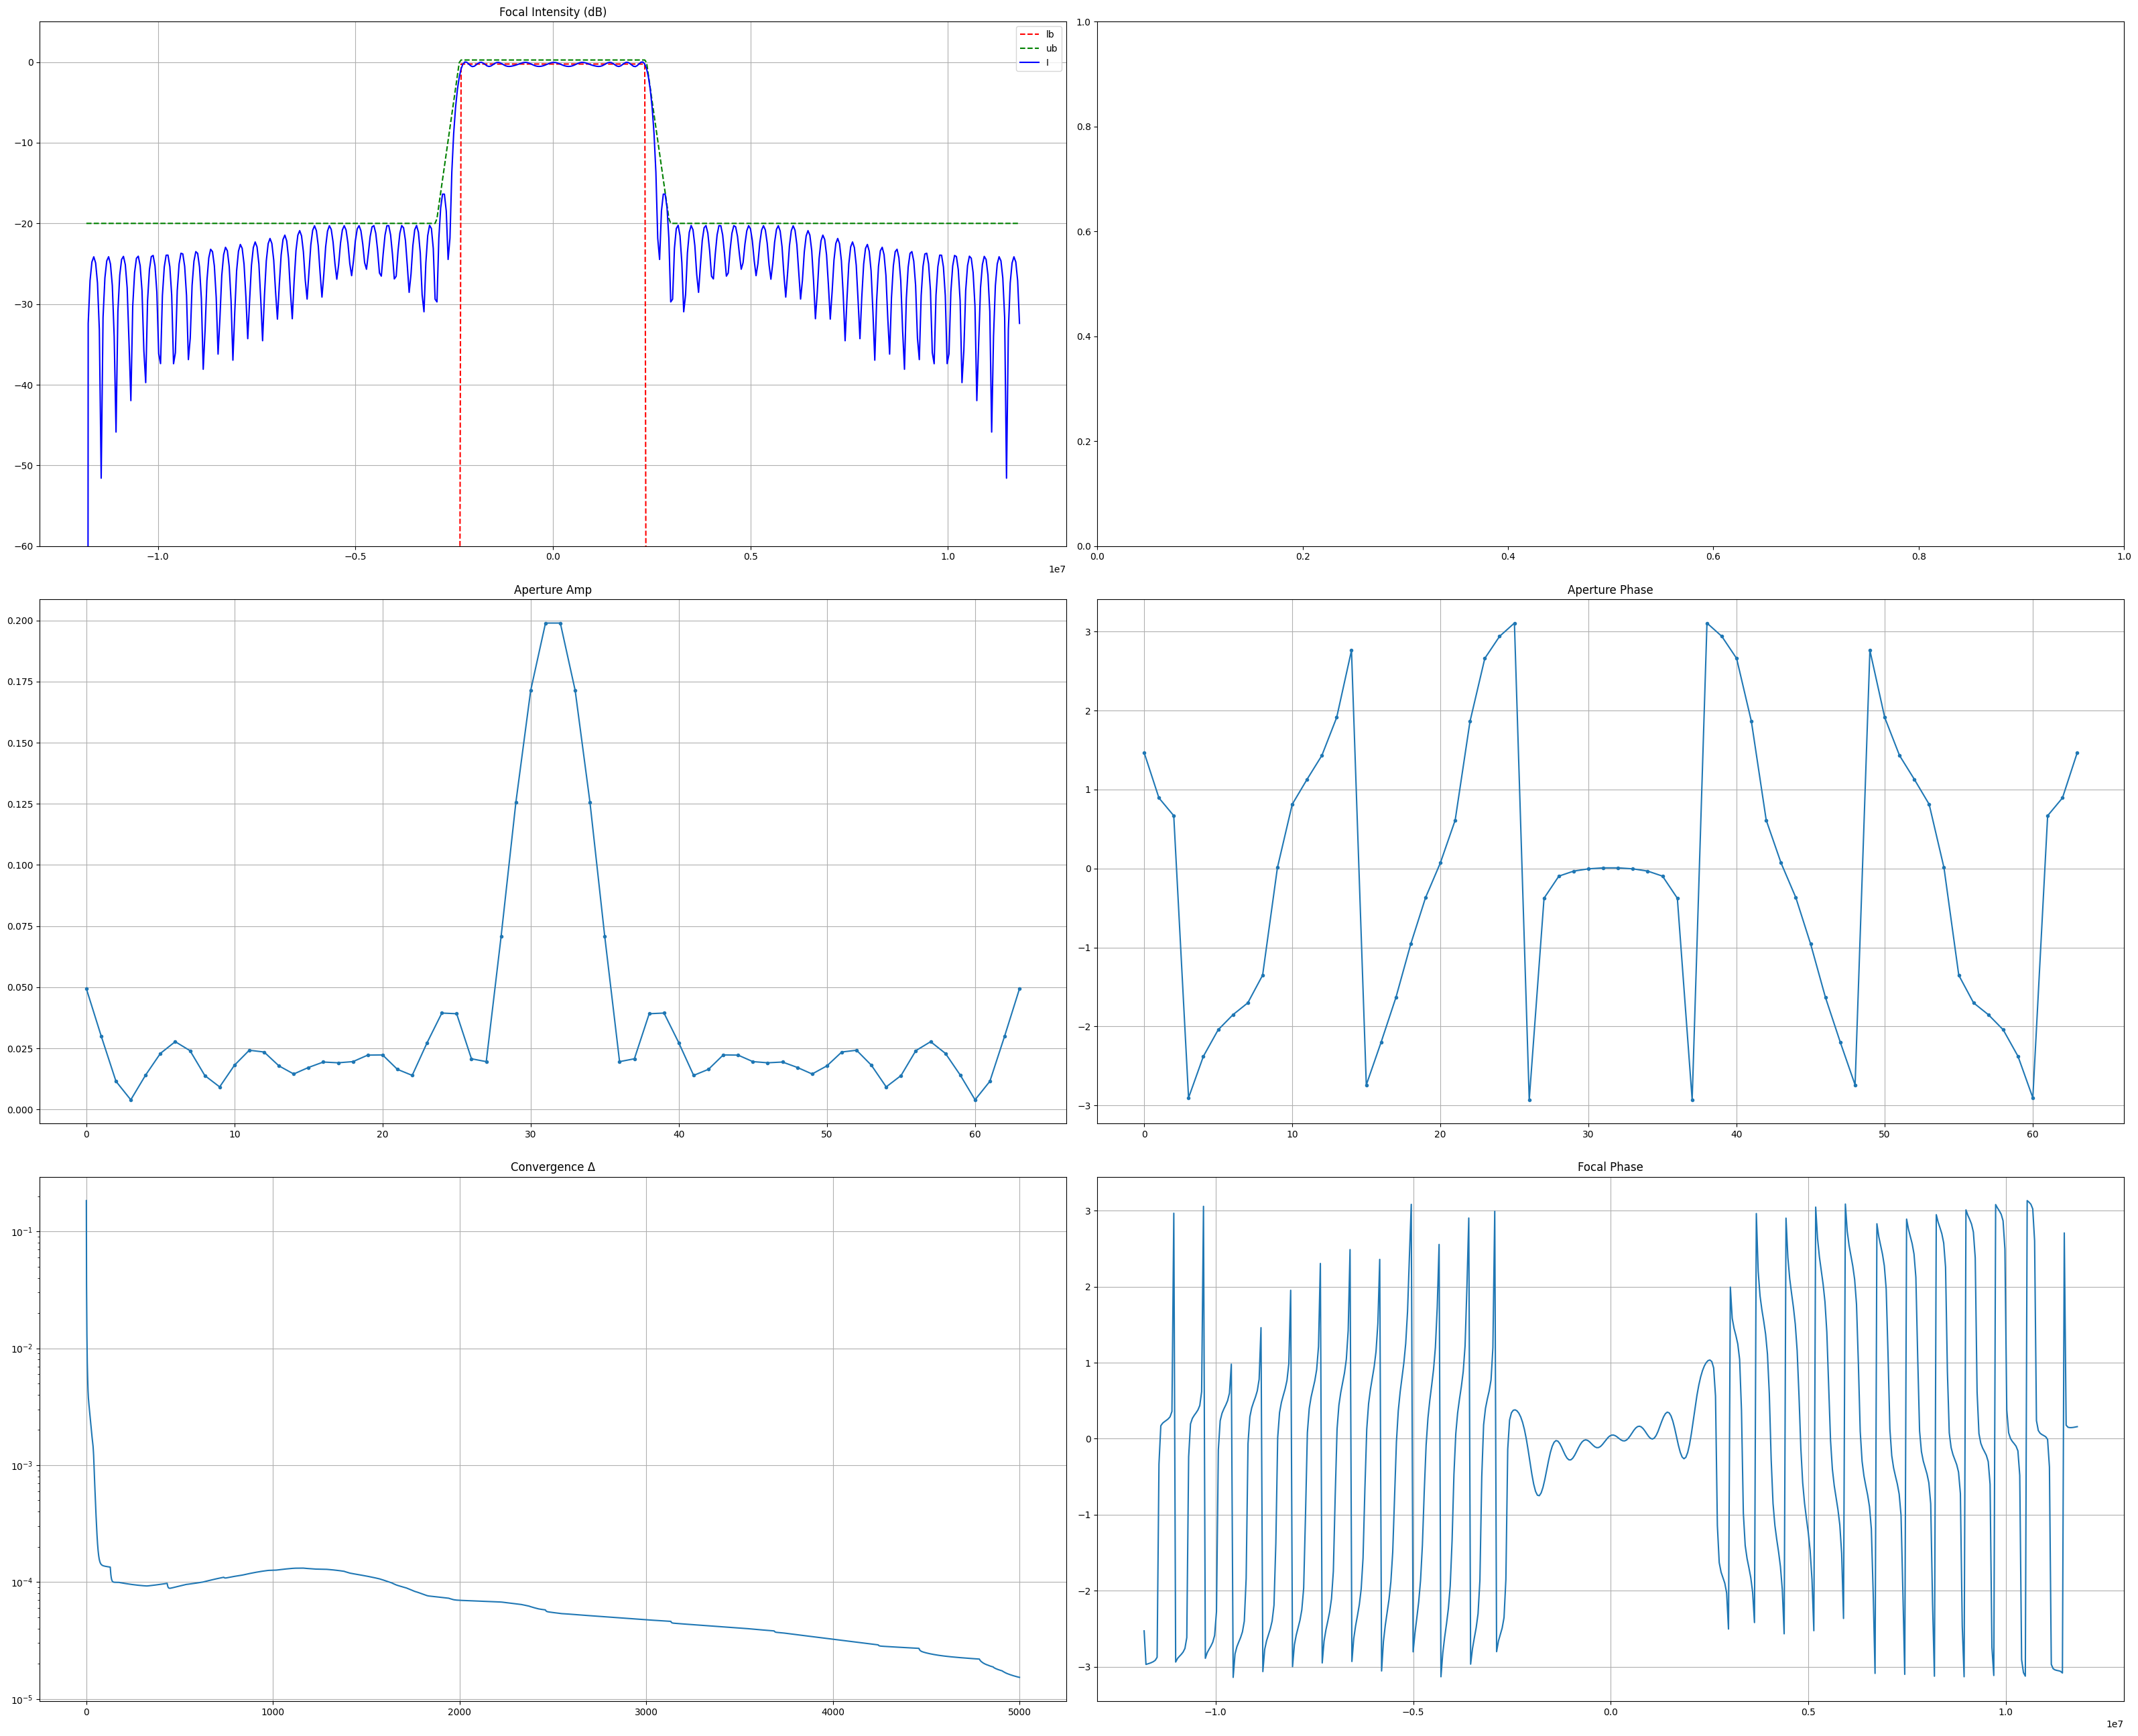

Aperture amplitude symmetric?  True
Peak sidelobe level: -1.1 dB


In [3]:
if __name__ == '__main__':
    # ========== Example parameters ==========
    M           = 64
    WAVEL       = 532e-9
    k_max       = 2*np.pi / WAVEL
    K           = 8*(M-1)
    k           = np.linspace(-k_max, k_max, K)

    # Mask specs
    main_w      = k_max/5
    trans_w     = k_max/20
    # dB levels
    main_db     = 0.25     # ±0.25 dB main
    ub_out_db   = -20.0    # –20 dB outside
    lb_flr_db   = -100.0   # –100 dB floor

    # linear amplitudes
    main_hi     = 10**( main_db   /20)
    main_lo     = 10**(-main_db   /20)
    ub_out      = 10**( ub_out_db /20)
    lb_flr      = 10**( lb_flr_db /20)

    lb          = lb_flr * np.ones(K)
    ub          = ub_out * np.ones(K)

    main        = np.abs(k) < main_w
    lb[main]    = main_lo
    ub[main]    = main_hi

    t           = (np.abs(k)-main_w)/trans_w
    t           = np.clip(t,0,1)
    ub_db       = main_db + (ub_out_db - main_db)*t
    ub_lin      = 10**(ub_db/20)

    trans       = (t>0)&(t<1)
    ub[trans]   = ub_lin[trans]

    # aperture support (all M active)
    support     = np.ones(M)

    # ====== Run POCS beam shaping ======
    shaper      = LaserBeamShaper(k, M, lb, ub, support)
    c, F, err   = shaper.optimize_beam(max_iter=5000, tol=1e-14, verbose=True)
    shaper.visualize_results()

    # check symmetry
    main_idx = main
    print("Aperture amplitude symmetric? ",
          np.allclose(np.abs(c), np.abs(c)[::-1], atol=1e-6))
    print("Peak sidelobe level:", f"{20*np.log10(np.max(np.abs(F[~main_idx])**2)):.1f} dB")
